# Image Classification with Convolutional Neural Networks

## Part 1: Load and process the data

In [25]:
import os
from glob import glob
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


### Methods

In [26]:
def load_images(basepath, label):
    filepaths = glob(os.path.join(basepath, f'{label}_*'))
    images = []
    labels = []
    for img in filepaths:
        images.append(Image.open(img))
        labels.append(label)
    return np.array(images, dtype=np.int64), np.array(labels, dtype=np.int64)

def split_train_test_val(images, labels, test_split, val_split, random_state):
    X_train, X_test_val, y_train, y_test_val = train_test_split(images, labels, test_size=test_split+val_split, random_state=random_state, shuffle=True, stratify=labels)
    X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=test_split/val_split, random_state=random_state, shuffle=True)
    return X_train, X_val, X_test, y_train, y_val, y_test

### Parameters

In [27]:
test_size = 0.1
val_size = 0.2
random_state= 42
basepath = 'data/01_raw/shipsnet/shipsnet/'
num_classes=2

### Logic

In [28]:
from keras.utils import to_categorical
ships, labels_ships = load_images(basepath, 1)
not_ships, labels_not_ships = load_images(basepath, 0)

print("No of ships images: ", len(ships))
print("No of not ships images: ", len(not_ships))

images = np.concatenate([ships, not_ships])
labels = to_categorical(np.concatenate([labels_ships, labels_not_ships]), num_classes=num_classes)

No of ships images:  1000
No of not ships images:  3000


In [29]:
X_train, X_val, X_test, y_train, y_val, y_test = split_train_test_val(images, labels, test_size, val_size, random_state)

### Visualise the data

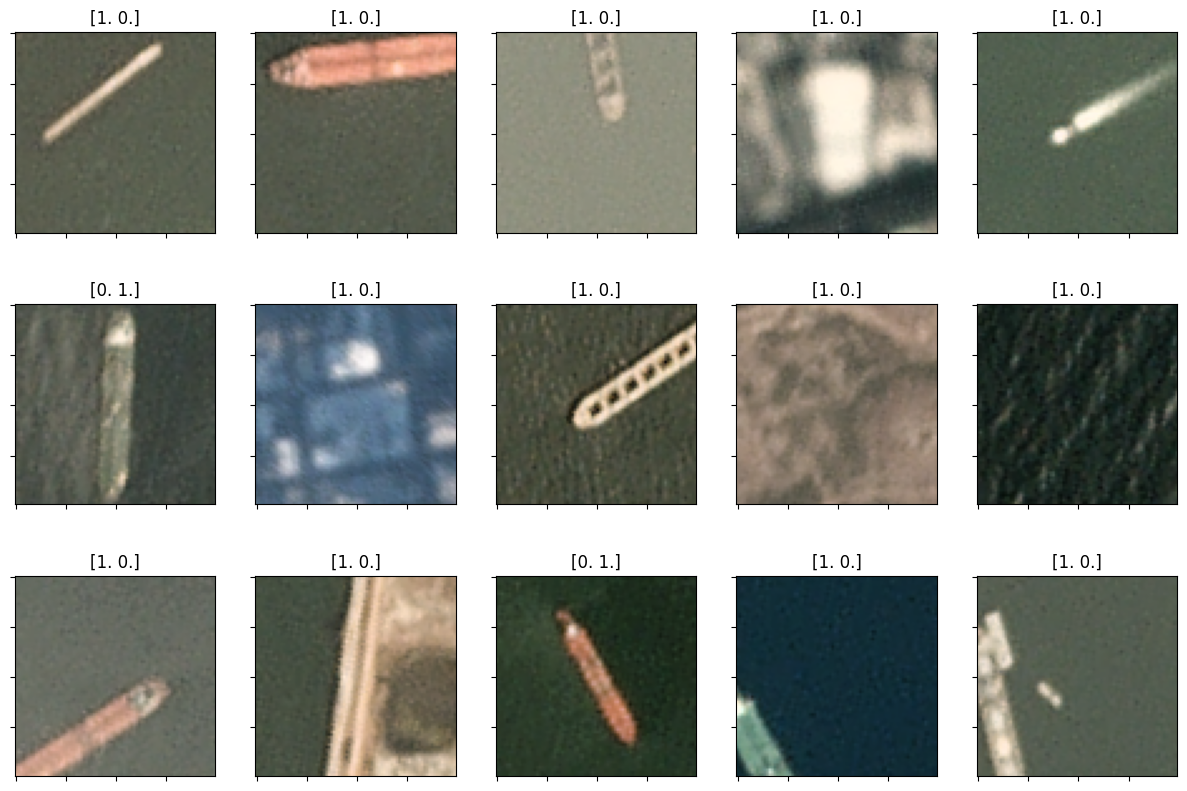

In [30]:
# Plot some sample images
import random

n_rows = 3
n_cols = 5

plt.figure(figsize=(15, 10))
for i in range(n_rows*n_cols):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    index = random.randint(0, len(X_train) - 1)
    index
    plt.imshow(X_train[index])
    plt.title(y_train[index])

## Part 2: Build and train the model

In [31]:
from keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    LeakyReLU,
    MaxPooling2D,
    Input,
)
from keras.models import Sequential

### Methods

In [32]:
def define_model(input_shape = (80, 80, 3), n_classes = 2):
    model = Sequential()

    model.add(Input(shape=input_shape))

    model.add(Conv2D(32, (3, 3), activation='linear', padding='same'))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), activation='linear', padding='same'))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (3, 3), activation='linear', padding='same'))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (3, 3), activation='linear', padding='same'))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())

    model.add(Flatten())

    model.add(Dense(256, activation='linear'))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())

    model.add(Dense(64, activation='linear'))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())

    model.add(Dense(n_classes, activation='softmax'))

    return model

def compile_model(model, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']):
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

def train_model(model, X_train, y_train, X_val, y_val, epochs, batch_size):
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=1)
    return model, history



### Parameters

In [33]:
input_shape = (80, 80, 3)
epochs = 5
batch_size = 16
loss = 'binary_crossentropy'
optimizer = 'adam'

### Logic

In [34]:
model = define_model(input_shape=input_shape, n_classes=num_classes)
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 80, 80, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 40, 40, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 40, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 256)            │             

 Total params: 2,046,850 (7.81 MB)

 Trainable params: 2,045,250 (7.80 MB)

 Non-trainable params: 1,600 (6.25 KB)

In [35]:
compiled_model = compile_model(model)
fitted_model, history = train_model(compiled_model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)

Epoch 1/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - accuracy: 0.7721 - loss: 0.5467 - val_accuracy: 0.9083 - val_loss: 0.2124
Epoch 2/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.9151 - loss: 0.2191 - val_accuracy: 0.9633 - val_loss: 0.1052
Epoch 3/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9403 - loss: 0.1666 - val_accuracy: 0.9050 - val_loss: 0.2014
Epoch 4/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - accuracy: 0.9421 - loss: 0.1537 - val_accuracy: 0.9783 - val_loss: 0.0657
Epoch 5/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.9460 - loss: 0.1178 - val_accuracy: 0.9767 - val_loss: 0.0633


## Part 3: Evaluate the model

In [36]:
import plotly.graph_objects as go

### Methods

In [37]:
def evaluate_model(model, X_test, y_test):
    score = model.evaluate(X_test, y_test)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

def report(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = list(range(len(accuracy)))
    fig_accuracy = go.Figure()
    fig_accuracy.add_trace(go.Scatter(x=epochs, y=accuracy, mode='lines', name='Training accuracy', line=dict(color='blue')))

    # Add Validation accuracy trace
    fig_accuracy.add_trace(go.Scatter(x=epochs, y=val_accuracy, mode='lines', name='Validation accuracy', line=dict(color='red')))

    # Set title and labels
    fig_accuracy.update_layout(
        title='Training and Validation Accuracy',
        xaxis_title='Epochs',
        yaxis_title='Accuracy'
    )

    fig_loss = go.Figure()

    # Add Training loss trace
    fig_loss.add_trace(go.Scatter(x=epochs, y=loss, mode='lines', name='Training loss', line=dict(color='blue')))

    # Add Validation loss trace
    fig_loss.add_trace(go.Scatter(x=epochs, y=val_loss, mode='lines', name='Validation loss', line=dict(color='red')))

    # Set title and labels
    fig_loss.update_layout(
        title='Training and Validation Loss',
        xaxis_title='Epochs',
        yaxis_title='Loss'
    )
    return fig_accuracy, fig_loss



In [38]:
evaluate_model(fitted_model, X_test, y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9792 - loss: 0.0551
Test loss: 0.049057796597480774
Test accuracy: 0.9850249290466309


In [39]:
fig_accuracy, fig_loss = report(history)
fig_accuracy.show()
fig_loss.show() 